### seq2seq

### 데이터 뒤집기

In [3]:
import numpy as np

a = np.array([1,2,3,4,5])
# a = np.flip(a)
a = a[::-1]
print(a)

[5 4 3 2 1]


In [4]:
import numpy as np

a = np.array([[1,2,3,4,5],
              [6,7,8,9,10]])
# a = np.flip(a)
a = a[:, ::-1]
print(a)

[[ 5  4  3  2  1]
 [10  9  8  7  6]]


In [21]:
a = np.arange(24).reshape(2,3,4)
b = np.arange(30).reshape(2,3,5)
print(a)
print(b)
out = np.concatenate((a, b), axis=2)
print(out.shape)
print(out)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]]

 [[15 16 17 18 19]
  [20 21 22 23 24]
  [25 26 27 28 29]]]
(2, 3, 9)
[[[ 0  1  2  3  0  1  2  3  4]
  [ 4  5  6  7  5  6  7  8  9]
  [ 8  9 10 11 10 11 12 13 14]]

 [[12 13 14 15 15 16 17 18 19]
  [16 17 18 19 20 21 22 23 24]
  [20 21 22 23 25 26 27 28 29]]]


In [8]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        print("h.shape = ", h.shape)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled


In [24]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
# from seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

#         print("xs.shape=", xs.shape)
        out = self.embed.forward(xs)
#         print("out.shape=", out.shape)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)
#         print("out.shape=", out.shape)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)
#         print("out.shape=", out.shape)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


13
{'1': 0, '6': 1, '+': 2, '7': 3, '5': 4, ' ': 5, '_': 6, '9': 7, '2': 8, '0': 9, '3': 10, '8': 11, '4': 12}
| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 6[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 7[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 7[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 8[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 8[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 

| 에폭 8 |  반복 321 / 351 | 시간 8[s] | 손실 0.35
| 에폭 8 |  반복 341 / 351 | 시간 8[s] | 손실 0.34
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 657 
---
Q 8+155  
T 163 
X 155 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1438
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 65.060%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 2[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 3[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 4[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 4[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 5[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 5[s] | 손실 0.25
| 에폭 9 |  반복 241 / 351 | 시간 6[s] | 손실 0.24
| 에폭 9 |  반복 261 / 351 | 시간 6[s] | 손실 0.24
| 에폭 9 |  반복 281 / 351 

| 에폭 16 |  반복 141 / 351 | 시간 3[s] | 손실 0.04
| 에폭 16 |  반복 161 / 351 | 시간 4[s] | 손실 0.04
| 에폭 16 |  반복 181 / 351 | 시간 4[s] | 손실 0.04
| 에폭 16 |  반복 201 / 351 | 시간 5[s] | 손실 0.04
| 에폭 16 |  반복 221 / 351 | 시간 5[s] | 손실 0.04
| 에폭 16 |  반복 241 / 351 | 시간 6[s] | 손실 0.05
| 에폭 16 |  반복 261 / 351 | 시간 6[s] | 손실 0.04
| 에폭 16 |  반복 281 / 351 | 시간 7[s] | 손실 0.04
| 에폭 16 |  반복 301 / 351 | 시간 8[s] | 손실 0.04
| 에폭 16 |  반복 321 / 351 | 시간 8[s] | 손실 0.04
| 에폭 16 |  반복 341 / 351 | 시간 9[s] | 손실 0.04
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 96.360%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.03
| 에폭 17

검증 정확도 92.580%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.05
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.07
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.07
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.05
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.04
| 에폭 24 |  반복 101 / 351 | 시간 2[s] | 손실 0.03
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.02
| 에폭 24 |  반복 141 / 351 | 시간 3[s] | 손실 0.02
| 에폭 24 |  반복 161 / 351 | 시간 4[s] | 손실 0.01
| 에폭 24 |  반복 181 / 351 | 시간 4[s] | 손실 0.01
| 에폭 24 |  반복 201 / 351 | 시간 5[s] | 손실 0.01
| 에폭 24 |  반복 221 / 351 | 시간 5[s] | 손실 0.01
| 에폭 24 |  반복 241 / 351 | 시간 6[s] | 손실 0.01
| 에폭 24 |  반복 261 / 351 | 시간 7[s] | 손실 0.01
| 에폭 24 |  반복 281 / 351 | 시간 7[s] | 손실 0.01
| 에폭 24 |  반복 301 / 351 | 시간 8[s] | 손실 0.01
| 에폭 24 |  반복 321 / 351 | 시간 8[s] | 손실 0.01
| 에폭 24 |  반복 341 / 351 | 시간 9[s] | 손실 0.01
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 8

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50640 missing from c

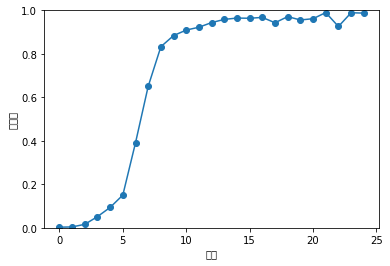

In [26]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse =  True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
print(vocab_size)
print(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()



### np.concatnate 테스트

In [11]:
out = np.arange(20).reshape(1,5,4)
print(out)
h = np.arange(3).reshape(1,3)
print(h)
hs = np.repeat(h, 5, axis=0).reshape(1, 5, 3)
print(hs)
out = np.concatenate((hs, out), axis=2)
print(out)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]
  [16 17 18 19]]]
[[0 1 2]]
[[[0 1 2]
  [0 1 2]
  [0 1 2]
  [0 1 2]
  [0 1 2]]]
[[[ 0  1  2  0  1  2  3]
  [ 0  1  2  4  5  6  7]
  [ 0  1  2  8  9 10 11]
  [ 0  1  2 12 13 14 15]
  [ 0  1  2 16 17 18 19]]]
